## Export mmdetection models to CoreML format

This notebook will try to convert models from the [mmdetection](https://github.com/open-mmlab/mmdetection) library to CoreML format. This script tries to solve a bunch of dependencies problems that I founded when trying to convert these models.


In [7]:
# firsts thing first, install the requirements.
!pip install -r requirements.txt

  Using cached ipyplot-1.1.2-py3-none-any.whl.metadata (7.2 kB)
  Using cached shortuuid-1.0.13-py3-none-any.whl.metadata (5.8 kB)
Using cached ipyplot-1.1.2-py3-none-any.whl (13 kB)
Using cached shortuuid-1.0.13-py3-none-any.whl (10 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [6]:
# import libraries
import os
import cv2
import numpy as np

We need to build libtorch, install mmdetection and mmdeploy according to the following docs:

https://mmdeploy.readthedocs.io/en/latest/01-how-to-build/macos-arm64.html

https://mmdeploy.readthedocs.io/en/latest/05-supported-backends/coreml.html

### 1. Build libtorch, the slow part.

In [19]:
PYTORCH_VERSION = "2.0.0"
PYTORCH_DIR= "third_party/pytorch"

Clone PyTorch version (~8min)

In [9]:
if not os.path.exists(PYTORCH_DIR):
    !git clone --recursive --depth 1 --branch v{PYTORCH_VERSION} https://github.com/pytorch/pytorch {PYTORCH_DIR}

Cloning into '../third_party/pytorch'...
remote: Enumerating objects: 12686, done.
remote: Counting objects: 100% (12686/12686), done.
remote: Compressing objects: 100% (10933/10933), done.
remote: Total 12686 (delta 1649), reused 9170 (delta 1467), pack-reused 0
Receiving objects: 100% (12686/12686), 84.29 MiB | 20.63 MiB/s, done.
Resolving deltas: 100% (1649/1649), done.
Note: switching to 'c263bd43e8e8502d4726643bc6fd046f0130ac0e'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Updating files: 100% (11881/11881), done.
Su

Build libtorch from source (~16min)

In [12]:
!cd {PYTORCH_DIR} && \
mkdir -p build && cd build && \
cmake .. \
    -DCMAKE_BUILD_TYPE=Release \
    -DPYTHON_EXECUTABLE=`which python` \
    -DCMAKE_INSTALL_PREFIX=install \
    -DDISABLE_SVE=ON

!cd {PYTORCH_DIR}/build/ && make -j4 && make install

-- CLANG_VERSION_STRING:         Apple clang version 15.0.0 (clang-1500.3.9.4)
Target: arm64-apple-darwin23.5.0
Thread model: posix
InstalledDir: /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin

-- sdk version: 14.5, mps supported: ON
-- MPSGraph framework found
-- Could not find ccache. Consider installing ccache to speed up compilation.
-- Turning off deprecation warning due to glog.
-- Building using own protobuf under third_party per request.
-- Use custom protobuf build.
CMake Deprecation Warning at third_party/protobuf/cmake/CMakeLists.txt:2 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- 
-- 3.13.0.0
-- Caffe2 protobuf include directory: $<BUILD_INTERFACE:/Users/gustavofuhr/projects/object_detection_ios_comprehensive/third_party

### 2. Build mmdeploy

We will need to build mmdeploy as well, more or less following what is described in the lib [docs](https://mmdeploy.readthedocs.io/en/latest/01-how-to-build/macos-arm64.html).

In [14]:
MMDEPLOY_DIR = "third_party/mmdeploy/"
COMMIT_HASH = "bc75c9d6c8940aa03d0e1e5b5962bd930478ba77"
!git -C {MMDEPLOY_DIR} pull || git clone --recursive https://github.com/open-mmlab/mmdeploy.git {MMDEPLOY_DIR}
!cd {MMDEPLOY_DIR} && git reset --hard {COMMIT_HASH}

fatal: cannot change to 'third_party/mmdeploy/': No such file or directory
Cloning into 'third_party/mmdeploy'...
remote: Enumerating objects: 25290, done.
remote: Counting objects: 100% (875/875), done.(193/875)
remote: Compressing objects: 100% (564/564), done.
remote: Total 25290 (delta 434), reused 592 (delta 259), pack-reused 24415
Receiving objects: 100% (25290/25290), 13.57 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (16137/16137), done.
Submodule 'third_party/cub' (https://github.com/NVIDIA/cub.git) registered for path 'third_party/cub'
Submodule 'third_party/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'third_party/pybind11'
Submodule 'third_party/spdlog' (https://github.com/gabime/spdlog.git) registered for path 'third_party/spdlog'
Cloning into '/Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/mmdeploy/third_party/cub'...
remote: Enumerating objects: 33392, done.        
remote: Counting objects: 1

First thing is that there is an error in the CMakeLists.txt that set the standard to C++14 instead of C++17. [See issue](https://github.com/open-mmlab/mmdeploy/issues/2638) for more details.

In [15]:
with open(f"{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists.txt", "r") as f, \
        open(f"{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists_fixed.txt", "w") as f_out:
    content = f.readlines()
    for ln in content:
        if "set(CMAKE_CXX_STANDARD 14)" in ln:
            ln = "    set(CMAKE_CXX_STANDARD 17)\n"
        f_out.write(ln)

os.rename(f'{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists_fixed.txt', f'{MMDEPLOY_DIR}/csrc/mmdeploy/backend_ops/CMakeLists.txt')
print("CMakeLists.txt updated")

CMakeLists.txt updated


In [22]:
Torch_DIR=os.getcwd()+"/third_party/pytorch/build/install/share/cmake/Torch"

print("will compile mmdeploy using torch from ", Torch_DIR)
!cd {MMDEPLOY_DIR} && \
    mkdir -p build && cd build && \
    cmake -DMMDEPLOY_TARGET_BACKENDS=coreml -DTorch_DIR={Torch_DIR} .. && \
    make -j4 && make install

will compile mmdeploy using torch from  /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/pytorch/build/install/share/cmake/Torch
-- CMAKE_INSTALL_PREFIX: /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/mmdeploy/build/install
-- Build torchscript custom ops
-- Found Torch: /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/pytorch/build/install/lib/libtorch.dylib
-- Configuring done (0.1s)
-- Generating done (0.0s)
-- Build files have been written to: /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/mmdeploy/build
[ 75%] Building CXX object csrc/mmdeploy/backend_ops/torchscript/ops/CMakeFiles/mmdeploy_torchscript_ops_obj.dir/bind.cpp.o
[ 75%] Building CXX object csrc/mmdeploy/backend_ops/torchscript/ops/CMakeFiles/mmdeploy_torchscript_ops_obj.dir/coreml_nms/coreml_nms_cpu.cpp.o
[ 75%] Building CXX o

In [36]:
!cd {MMDEPLOY_DIR} && pip install -v -e .

Using pip 24.0 from /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/pip (python 3.10)
Obtaining file:///Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/mmdeploy
  Preparing metadata (setup.py) ...   Running command python setup.py egg_info
  /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/setuptools/installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer.
    warnings.warn(
  running egg_info
  creating /private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-wr6tfjy4/mmdeploy.egg-info
  writing manifest file '/private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-wr6tfjy4/mmdeploy.egg-info/SOURCES.txt'
  /Users/gustavofuhr/projects/object_detecti

### 3. Install mmdetection from source

In [24]:
MMDETECTION_DIR = "third_party/mmdetection/"
COMMIT_HASH = "cfd5d3a985b0249de009b67d04f37263e11cdf3"
!git -C {MMDETECTION_DIR} pull || git clone --recursive https://github.com/open-mmlab/mmdetection.git {MMDETECTION_DIR}
!cd {MMDETECTION_DIR} && git reset --hard {COMMIT_HASH}

fatal: cannot change to 'third_party/mmdetection/': No such file or directory
Cloning into 'third_party/mmdetection'...
remote: Enumerating objects: 38023, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 38023 (delta 0), reused 1 (delta 0), pack-reused 38021
Receiving objects: 100% (38023/38023), 63.25 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (26223/26223), done.
HEAD is now at cfd5d3a9 Release MM-GroundingDINO SwinB and SwinL Weights (#11460)


In [26]:
!mim install mmengine
!mim install "mmcv >=2.0.0rc4, < 2.1.0"

Looking in links: https://download.openmmlab.com/mmcv/dist/cpu/torch2.0.0/index.html
  Using cached mmengine-0.10.4-py3-none-any.whl.metadata (20 kB)
  Using cached addict-2.4.0-py3-none-any.whl.metadata (1.0 kB)
  Using cached matplotlib-3.9.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached yapf-0.40.2-py3-none-any.whl.metadata (45 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached contourpy-1.2.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.53.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (162 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pillow-10.4.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_me

In [32]:
!cd {MMDETECTION_DIR}; pip install -v -e .

Using pip 24.0 from /Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/.mmdetection_to_coreml/lib/python3.10/site-packages/pip (python 3.10)
Obtaining file:///Users/gustavofuhr/projects/object_detection_ios_comprehensive/mmdetection_to_coreml/third_party/mmdetection
  Preparing metadata (setup.py) ...   Running command python setup.py egg_info
  running egg_info
  creating /private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-myy2i4h9/mmdet.egg-info
  writing manifest file '/private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-myy2i4h9/mmdet.egg-info/SOURCES.txt'
  writing manifest file '/private/var/folders/s_/b7st6pwd6w5b70vzffb1vb2r0000gn/T/pip-pip-egg-info-myy2i4h9/mmdet.egg-info/SOURCES.txt'
done
  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/e1/03/8738c457ca04aed97f79781827b20862e78262da7ccc8062bcc6d6e857e2/pycocotools-2.0.8-cp310-cp310-macosx_10_9_universal2

#### 4. Finally, convert the detector model!

Download the models

In [33]:
#if not os.path.exists("retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth"):
#    !wget https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r18_fpn_1x_coco/retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth .
if not os.path.exists("rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth"):
    !wget https://download.openmmlab.com/mmdetection/v3.0/rtmdet/rtmdet_tiny_8xb32-300e_coco/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth .

--2024-07-14 20:59:12--  https://download.openmmlab.com/mmdetection/v2.0/retinanet/retinanet_r18_fpn_1x_coco/retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 128.14.249.242, 128.14.249.241, 128.14.249.243, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|128.14.249.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85719203 (82M) [application/octet-stream]
Saving to: ‘retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth’

retinanet_r18_fpn_1 100%[===================>]  81,75M  7,40MB/s    in 11s     

2024-07-14 20:59:24 (7,63 MB/s) - ‘retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth’ saved [85719203/85719203]

--2024-07-14 20:59:24--  http://./
Resolving . (.)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘.’
FINISHED --2024-07-14 20:59:24--
Total wall clock time: 12s
Downloaded: 1 files, 82M in 11s (7,63 MB/s)
--2024-07

Now will conver the model do CoreML, hopefully. I got an error when running the conversion script in a notebook, because it tried to open matplotlib to show some errors. That's why there is `MPLBACKEND="template"` there.

In [26]:
# !cd third_party/ && MPLBACKEND="template" && python mmdeploy/tools/deploy.py \
#     mmdeploy/configs/mmdet/detection/detection_coreml_static-800x1344.py \
#     mmdetection/configs/retinanet/retinanet_r18_fpn_1x_coco.py \
#     ../retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth \
#     mmdetection/demo/demo.jpg \
#     --work-dir ../work_dir/retinanet \
#     --device cpu \
#     --dump-info


!cd third_party/ && MPLBACKEND="template" && python mmdeploy/tools/deploy.py \
    mmdeploy/configs/mmdet/detection/detection_coreml_static-800x1344.py \
    mmdetection/configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py \
    ../rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth \
    mmdetection/demo/demo.jpg \
    --work-dir ../work_dir/rtmdet \
    --device cpu \
    --dump-info

07/15 17:57:04 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "Codebases" registry tree. As a workaround, the current "Codebases" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
07/15 17:57:04 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "mmdet_tasks" registry tree. As a workaround, the current "mmdet_tasks" registry in "mmdeploy" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
07/15 17:57:05 - mmengine - INFO - Start pipeline mmdeploy.apis.pytorch2torchscript.torch2torchscript in subprocess
07/15 17:57:05 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "Codebases" registry tree. As a workaround, the current "Codebas

If everything worked out, you should have a .mlpackage with the CoreML converted model (including NMS). It's a good idea to open it in Xcode to check some metadata.

In [55]:
#!du -sh retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth
#!du -sh work_dir/retinanet/end2end.mlpackage/

!du -sh rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
!du -sh work_dir/rtmdet/end2end.mlpackage/

 82M	retinanet_r18_fpn_1x_coco_20220407_171055-614fd399.pth
 85M	work_dir/retinanet/end2end.mlpackage/


The conversion script creates a lot of files in the `work_dir` directory. MMdeploy make inferences in both models so that we can check if that worked:

In [61]:
import ipyplot

images = ["work_dir/retinanet/output_pytorch.jpg", "work_dir/retinanet/output_coreml.jpg"]
labels = ["PyTorch", "CoreML"]
ipyplot.plot_images(images, labels, img_width=400)

### 5. CoreML inference

Now let's run inference using the coremltools backend. This basically means that we will not use mmdetection to pre-process the images and we'll need to figure out what is the output.

Pre-processing images comes from these files:
- `mmdetection/configs/_base_/datasets/coco_detection.py`
- `mmdetection/configs/rtmdet/rtmdet_l_8xb32-300e_coco.py`

For some strange reason, mean/std values can be different for different detectors.

In [65]:
def preprocess_image(image_path):
    im = cv2.imread(image_path)
    im = cv2.resize(im, (1344, 800))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im.astype(np.float32)
    # im /= 255 no need, since mean and std are with respect to 255

    # mean and std values taken from rtmdet_l_8xb32-300e_coco.py file
    mean=[103.53, 116.28, 123.675],
    std=[57.375, 57.12, 58.395],

    im -= mean
    im /= std

    im = im.transpose(2, 0, 1) # HWC -> CHW
    im = np.expand_dims(im, 0)  # Add batch dimension.

    return im

The output of the CoreML model (for RTMDet) will be a dictionary with two items:
- dets: this is a tensor of size 1x200x5 that represent 200 boxes that would be predicted by the model. Each box comes with four coordinates and a score (which we should apply a threshold); the boxes are returned in decreasing order of score, which is cool!
- labels: this is a an array of 200 integers given class numbers (coco) for each box

In [114]:

from mmdet.datasets.coco import CocoDataset
coco_classes = CocoDataset.METAINFO["classes"]

def postprocess_output(output, threshold = 0.5):
    boxes = output["dets"][0,:,:]
    id_good_boxes = np.where(boxes[:,4] > threshold)  # boxes above threshold
    
    good_boxes = boxes[id_good_boxes, :][0]
    good_labels = output["labels"][0, id_good_boxes][0]

    detections = []
    for box, label in zip(good_boxes, good_labels):
        detections.append({"label": coco_classes[label], "box": box[:4].tolist(), "score": box[4]})

    return detections

Quick function to plot object detection

In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_detections(image_path, detections, detector_size):
    im = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(10, 10))
    
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    for detection in detections:
        box = detection["box"]
        # scale box according to detector_size
        scale_x = im.shape[1] / detector_size[0]
        scale_y = im.shape[0] / detector_size[1]
        box = [box[0] * scale_x, box[1] * scale_y, box[2] * scale_x, box[3] * scale_y]
        
        label = detection["label"]
        score = detection["score"]
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f"{label} {score:.2f}", backgroundcolor="white", color="red")

    plt.axis('off')
    plt.show()



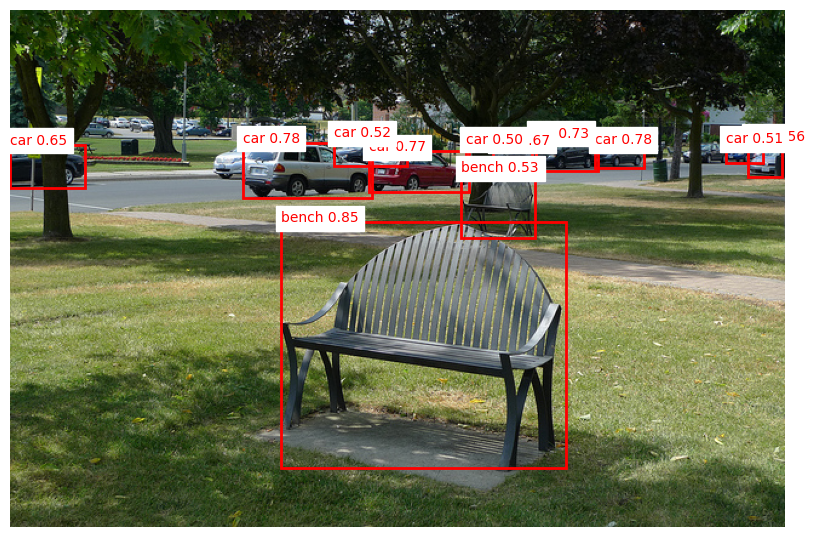

In [116]:
import coremltools as ct

model = ct.models.MLModel("work_dir/rtmdet/end2end.mlpackage", compute_units=ct.ComputeUnit.ALL)
pred = model.predict({"input": preprocess_image("third_party/mmdetection/demo/demo.jpg")})

plot_detections("third_party/mmdetection/demo/demo.jpg", postprocess_output(pred), detector_size=(1344, 800))

